In [3]:
# ========================================================================
# IMPORTACIÓN DE LIBRERÍAS
# ========================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import make_classification

# ========================================================================
# CREACIÓN DE UN DATASET DE EJEMPLO (puedes reemplazarlo con tu CSV)
# ========================================================================
datos, etiquetas = make_classification(
    n_samples=200, n_features=2, n_redundant=0,
    n_informative=2, random_state=123, n_clusters_per_class=1
)
datos = pd.DataFrame(datos, columns=['X1', 'X2'])
datos['y'] = etiquetas

# ========================================================================
# DIVISIÓN DE LOS DATOS EN TRAIN Y TEST
# ========================================================================
X = datos.drop(columns='y')
y = datos['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.8,
    random_state=1234,
    shuffle=True
)

# ========================================================================
# GRID DE HIPERPARÁMETROS
# ========================================================================
param_grid = {'C': np.logspace(-5, 7, 20)}  # 20 valores entre 10^-5 y 10^7

# ========================================================================
# BÚSQUEDA POR VALIDACIÓN CRUZADA
# ========================================================================
grid = GridSearchCV(
    estimator=SVC(kernel="rbf", gamma='scale'),
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=3,
    verbose=1,
    return_train_score=True
)

# Entrenamiento del modelo con búsqueda de hiperparámetros
grid.fit(X_train, y_train)

# ========================================================================
# RESULTADOS DE LA BÚSQUEDA
# ========================================================================
resultados = pd.DataFrame(grid.cv_results_)

# Mostrar las 5 mejores configuraciones
mejores = resultados.filter(regex='(param.*|mean_t|std_t)') \
                    .drop(columns='params') \
                    .sort_values('mean_test_score', ascending=False) \
                    .head(5)

print("📊 Mejores configuraciones de C:")
print(mejores)

# Mostrar el mejor modelo encontrado
print("\n🏆 Mejor modelo encontrado:")
print(grid.best_estimator_)




Fitting 3 folds for each of 20 candidates, totalling 60 fits
📊 Mejores configuraciones de C:
        param_C  mean_test_score  std_test_score  mean_train_score  \
9      4.832930         0.937340        0.018118          0.946835   
6      0.061585         0.931167        0.009389          0.937518   
7      0.263665         0.931167        0.009389          0.943778   
8      1.128838         0.931167        0.009389          0.943778   
13  1623.776739         0.912416        0.009553          0.962499   

    std_train_score  
9          0.009102  
6          0.008689  
7          0.007452  
8          0.007452  
13         0.000166  

🏆 Mejor modelo encontrado:
SVC(C=np.float64(4.832930238571752))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


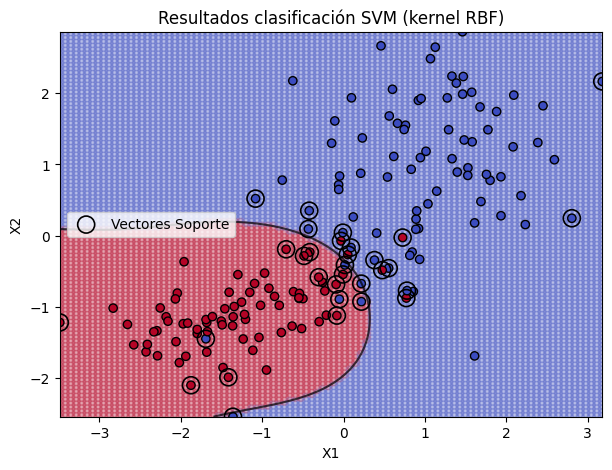

In [4]:
# ========================================================================
# REPRESENTACIÓN GRÁFICA DE LOS LÍMITES DE CLASIFICACIÓN
# ========================================================================
# Usamos el mejor modelo encontrado por GridSearchCV
modelo = grid.best_estimator_

# Creamos un grid de puntos (rejilla) para graficar los límites
x = np.linspace(np.min(X_train['X1']), np.max(X_train['X1']), 100)
y = np.linspace(np.min(X_train['X2']), np.max(X_train['X2']), 100)
Y, X = np.meshgrid(y, x)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T

# Predicción de las clases para cada punto del grid
pred_grid = modelo.predict(grid_points)

# Gráfica
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(grid_points[:,0], grid_points[:,1], c=pred_grid, alpha=0.2, cmap='coolwarm')
ax.scatter(X_train['X1'], X_train['X2'], c=y_train, cmap='coolwarm', edgecolors='k')

# Vectores soporte
ax.scatter(
    modelo.support_vectors_[:, 0],
    modelo.support_vectors_[:, 1],
    s=150, linewidth=1.2,
    facecolors='none', edgecolors='black', label='Vectores Soporte'
)

# Hiperplano de separación
ax.contour(
    X, Y,
    modelo.decision_function(grid_points).reshape(X.shape),
    colors='k',
    levels=[0],
    alpha=0.7,
    linestyles='-'
)

ax.set_title("Resultados clasificación SVM (kernel RBF)")
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.legend()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


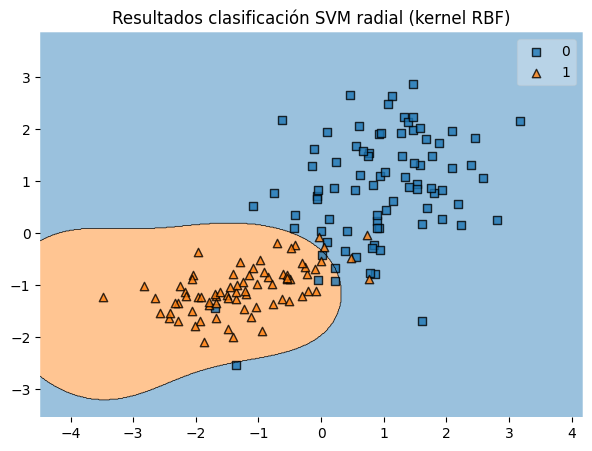


✅ El accuracy de test es: 87.50%

📊 Matriz de confusión:
Predicción   0   1
Real              
0           17   0
1            5  18


/tmp/ipython-input-3042819905.py:36: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_test.ravel(),


In [6]:
# ========================================================================
# IMPORTAR LIBRERÍAS NECESARIAS
# ========================================================================
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score, confusion_matrix

# ========================================================================
# REPRESENTACIÓN GRÁFICA UTILIZANDO plot_decision_regions() DE MLXTEND
# ========================================================================
fig, ax = plt.subplots(figsize=(7,5))
plot_decision_regions(
    X = X_train.to_numpy(),
    y = y_train.to_numpy(),
    clf = modelo,
    ax = ax
)
ax.set_title("Resultados clasificación SVM radial (kernel RBF)")
plt.show()

# ========================================================================
# PREDICCIONES EN EL CONJUNTO DE TEST
# ========================================================================
predicciones = modelo.predict(X_test)

# ========================================================================
# ACCURACY DEL MODELO EN TEST
# ========================================================================
accuracy = accuracy_score(y_true=y_test, y_pred=predicciones)
print("")
print(f"✅ El accuracy de test es: {100*accuracy:.2f}%")

# ========================================================================
# MATRIZ DE CONFUSIÓN DE LAS PREDICCIONES DE TEST
# ========================================================================
matriz_confusion = pd.crosstab(
    y_test.ravel(),
    predicciones,
    rownames=['Real'],
    colnames=['Predicción']
)

print("\n📊 Matriz de confusión:")
print(matriz_confusion)
